# EPU

EPU(Economic Policy Uncertainty) Index with KDI Economic Policy Information Database

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# for colab
"""!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!cd Mecab-ko-for-Google-Colab
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh
"""

'!pip install konlpy\n!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git\n!cd Mecab-ko-for-Google-Colab\n!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh\n'

In [49]:
# from konlpy.tag import Mecab
# tagger = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

In [6]:
import os

folder_path = '../data'
all_files = os.listdir(folder_path)

# 2. "epic_metadata_"로 시작하는 파일 필터링
xlsx_files = [f for f in all_files if f.startswith('epic_metadata_') and f.endswith('.xlsx')]

# 3. 각 파일을 읽어서 데이터프레임으로 변환
df_list = []
for file in xlsx_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    df_list.append(df)

# 4. 모든 데이터프레임을 하나로 연결
combined_df = pd.concat(df_list, ignore_index=True)

In [50]:
combined_df.head()

,Unnamed: 0,자료명,발간일,발간처,요약
0,249781,2024년 2월 온라인쇼핑동향,2024.04.01,통계청,통계청은 4.1.(월) 2024년 2월 온라인쇼핑 동향을 발표하였다.\n\n- (총...
1,249782,「아세안+3 재무차관 및 중앙은행 부총재 회의」 참석,2024.04.01,기획재정부 국제금융국 금융협력과,기획재정부는 「아세안+3 재무차관 및 중앙은행 부총재 회의」에 참석한다고 4.1.(...
2,249783,조달청-충북보건과학대학교 ‘협업’…공공조달 전문인력 양성,2024.04.01,조달청,조달청과 충북보건과학대학교는 4.1.(월) 조달청 대회의실에서 공공조달분야 전문인력...
3,249784,한국산업인력공단 ‘글로벌숙련부문 미래지식포럼’ 개최,2024.03.30,한국산업인력공단,한국산업인력공단은 3.29.(금) 글로벌숙련기술진흥원에서 숙련기술 분야 내·외부 전...
4,249785,"공정·청렴·투명·소통으로 조달청, 신뢰받는 중앙조달 기관으로",2024.04.01,조달청,조달청은 공정하고 투명한 일 처리로 국민에게 신뢰받는 중앙조달 기관으로 자리매김하기...


In [16]:
df = combined_df.sort_values('발간일').reset_index(drop=True).iloc[6:][['자료명', '발간일','요약']].reset_index(drop=True)

In [17]:
df

,자료명,발간일,요약
0,"고용노동 분야 대표 전문가들 한자리에 모여, 디지털 시대에 맞는 노동법 체계 개선 ...",2022.09.29,"노동 3대 학회가 주최하고, 미래노동시장 연구회가 주관하는 「디지털시대, 일하는 방..."
1,화이자 코로나 2가 백신 안전성·효과성 검증자문단 통과,2022.09.30,식품의약품안전처는 한국화이자제약의 코로나19 2가 백신 ‘코미나티2주0.1mg/mL...
2,상병수당 시범사업‘집중신청기간’운영,2022.09.30,보건복지부는 10.4(화)~11.11(금)까지 약 1개월 반 동안 상병수당 시범사업...
3,"내 질병, 혹시 직업병은 아닐까 의심해 보세요",2022.09.30,고용노동부는 9.30.(금) 서울 프레지던트 호텔에서 「전국 직업병 안심센터 워크숍...
4,「2022 전국 장애학생 진로드림 축제」개최,2022.09.30,교육부와 울산광역시교육청은 ‘2022 전국 장애학생 진로드림 축제’를 10.4(화)...
...,...,...,...
19876,국민이 제안하고 함께 풀어갈 ‘민생규제 개선과제’를 찾습니다,2024.05.01,행정안전부는 5.1.(수)~31.(금)까지 「2024년 민생규제 개선과제 공모」를 ...
19877,일상에서 사람을 돕고 맞춤형 서비스를 제공하는 자율행동체 SW 핵심기술개발 착수,2024.05.01,"과학기술정보통신부와 정보통신기획평가원은 4.30.(화) 돌봄, 간병 등 다양한 영역..."
19878,"재난안전의무보험 꼼꼼하게 챙겨 보려면, 종합정보시스템을 이용하세요",2024.05.01,행정안전부는 5.1.(수)부터 19개 중앙부처에서 개별적으로 관리하는 58종의 재난...
19879,"해수부-해경, 조업질서 확립 위해 불법조업 외국어선 처벌 강화한다",2024.05.01,해양수산부는 해양경찰청과 함께 불법조업 외국어선에 대한 대응을 강화하기 위해 5.1...


In [145]:
data = df.copy()

# keywords = ['불확실성', '불확실', '위기', '위험', '리스크', '불안', '우려', '걱정'] #EPU_KOR_4
keywords = ['불확실성', '불확실'] # EPU_baker
# keywords = ['불확실', '불안']

# '요약' 컬럼에 지정된 단어가 포함되어 있는지 확인하는 함수
def contains_keyword(text):
    return int(any(keyword in text for keyword in keywords))

# 새로운 컬럼 '불확실여부' 생성
data['불확실여부'] = data['요약'].apply(contains_keyword)

In [146]:
# '발간일' 컬럼을 datetime 형식으로 변환
data['발간일'] = pd.to_datetime(data['발간일'])
data = data[(data['발간일'] >= '2022-10-01') & (data['발간일'] <= '2024-04-30')]

# 일별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
daily_counts = data.groupby(data['발간일'].dt.date)['불확실여부'].agg(['count', 'sum'])
daily_counts.columns = ['total_count', 'uncertainty_count']

# 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
daily_counts['불확실도'] = daily_counts['uncertainty_count'] / daily_counts['total_count']

# 1) 불확실도를 계산한 데이터프레임을 날짜를 인덱스로 설정
daily_uncertainty_index = daily_counts['불확실도']

# 2) 불확실건수로
#daily_uncertainty_index = daily_counts['uncertainty_count']

In [147]:
monthly_counts = data.groupby(data['발간일'].dt.to_period('M'))['불확실여부'].agg(['count', 'sum'])
monthly_counts.columns = ['total_count', 'uncertainty_count']

# 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
monthly_counts['불확실도'] = monthly_counts['uncertainty_count'] / monthly_counts['total_count']

# 1) 불확실도를 계산한 데이터프레임을 월을 인덱스로 설정
monthly_uncertainty_index = monthly_counts['불확실도']

# 2) 불확실건수로
# monthly_uncertainty_index = monthly_counts['uncertainty_count']

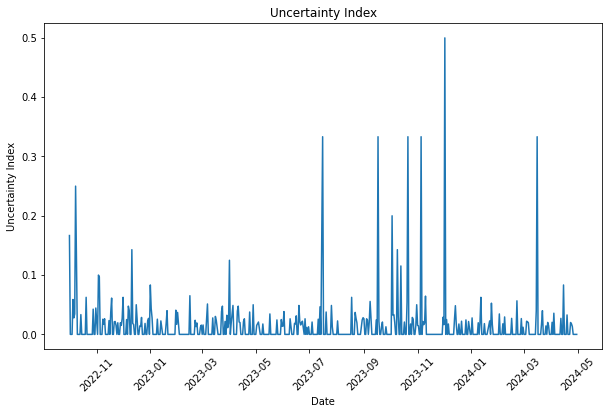

In [148]:
# 선 그래프 그리기
plt.figure(figsize=(10, 6))
daily_uncertainty_index.plot()
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.xticks(rotation=45)
plt.show()

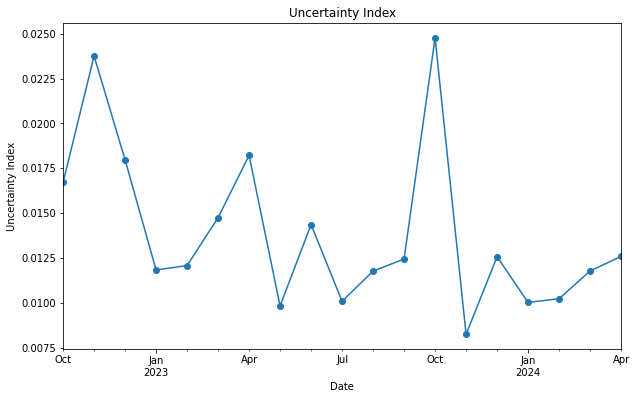

In [149]:
# 선 그래프 그리기
plt.figure(figsize=(10, 6))
monthly_uncertainty_index.plot(marker='o')
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')

plt.show()

# 기타

**건수가 아닌 비율로 해야하는 이유**

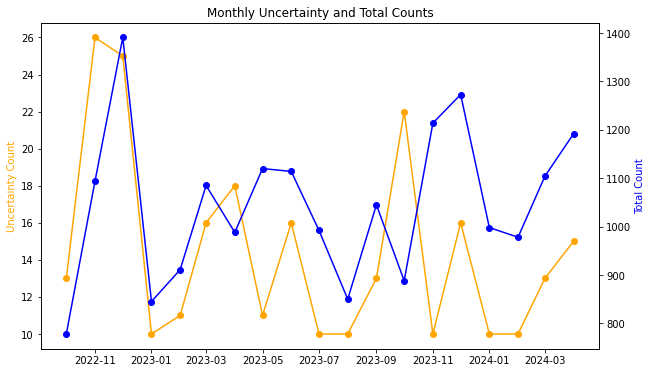

In [150]:
monthly_counts2 = monthly_counts.copy()
monthly_counts2.index = monthly_counts2.index.to_timestamp()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_ylabel('Uncertainty Count', color='orange')
ax1.plot(monthly_counts2['uncertainty_count'], marker='o', color='orange')
#ax1.set_xlabel('Date')

# 두 번째 y축
ax2 = ax1.twinx()
ax2.set_ylabel('Total Count', color='blue')
ax2.plot(monthly_counts2['total_count'], marker='o', color='blue')

plt.title('Monthly Uncertainty and Total Counts')
plt.show()

12월의 경우 보도 건수가 많기 때문에, '불확실성' 포함 보도도 많다.